In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr, moment

from IPython.display import display

# 1. Trim our data.

## 1.1. Read in data and have a look at it.

In [2]:
# read raw data.
data_raw = pd.read_csv('dat_final.csv')

print('head of raw data:')
display(data_raw.head())
print('description of raw data')
data_raw.describe()

head of raw data:


,Date,Time,sec_id,fut_ret,vol,X1,X2,X3,X4,X5,X6,X7
0,0,0,0,0.037521,0.000563,0.002766,-0.000187,0.000000,0.0,-0.000170,0.0,0.000000e+00
1,0,0,1,0.005565,0.000805,-0.000461,-0.000231,0.000000,0.0,0.000282,0.0,0.000000e+00
2,0,0,2,-0.008732,0.000584,0.001580,-0.000082,-0.000464,0.0,-0.000234,0.0,3.921761e-13
3,0,0,3,0.000695,0.000326,0.000243,-0.000125,0.000000,0.0,0.000104,0.0,0.000000e+00
4,0,0,4,-0.002755,0.000461,0.000259,-0.000291,0.000000,0.0,0.000138,0.0,0.000000e+00


description of raw data


,Date,Time,sec_id,fut_ret,vol,X1,X2,X3,X4,X5,X6,X7
count,392539.000000,392539.0,392539.000000,392539.000000,362441.000000,392539.000000,3.925390e+05,392539.000000,392539.000000,3.925390e+05,392539.000000,392539.000000
mean,99.415750,0.0,994.498906,0.000135,0.000564,0.000315,4.680045e-07,-0.000008,0.000031,8.290503e-08,-0.000037,0.000001
std,57.753533,0.0,574.905400,0.017272,0.000186,0.001151,2.999635e-04,0.000086,0.000282,2.997019e-04,0.000203,0.000017
min,0.000000,0.0,0.000000,-1.917905,0.000000,-0.009900,-1.391000e-03,-0.001497,0.000000,-1.475798e-03,-0.008484,0.000000
25%,49.000000,0.0,497.000000,-0.006237,0.000418,-0.000056,-2.020000e-04,0.000000,0.000000,-2.016605e-04,0.000000,0.000000
50%,99.000000,0.0,993.000000,0.000000,0.000548,0.000100,-0.000000e+00,0.000000,0.000000,-2.529583e-08,0.000000,0.000000
75%,149.000000,0.0,1492.000000,0.006087,0.000692,0.000768,2.030000e-04,0.000000,0.000000,2.021301e-04,0.000000,0.000000
max,199.000000,0.0,1991.000000,0.710399,0.002324,0.009900,1.422000e-03,0.000000,0.009157,1.399313e-03,0.000000,0.000817


From the description, we notice that
- The label 'Time' is invalid. So we drop it.
- 'fut_ret' is more likely to be residual return rather than raw return, since its sample average is very close to 0.

## 1.2. Drop 'Time' label.

In [3]:
np.sum(data_raw['Time']!=0)  # make sure all values are 0.

0

In [4]:
data = data_raw.drop(columns=['Time'])  # drop 'Time'.

## 1.3. Plot correlation heatmap pairwise among features.

In [5]:
corr = data.corr()
corr.style.background_gradient(cmap='binary')

,Date,sec_id,fut_ret,vol,X1,X2,X3,X4,X5,X6,X7
Date,1,-0.000360042,0.000959238,-0.037649,0.00178204,0.00150207,0.0154429,-0.0109058,-0.00469048,0.0328281,-0.00314545
sec_id,-0.000360042,1,0.00386634,0.294814,0.00979511,-0.00243256,-0.00658754,-0.0231365,0.00279693,0.0175532,0.000984823
fut_ret,0.000959238,0.00386634,1,0.0108265,0.0296427,-0.00100191,0.00238215,0.00126917,-0.00137804,0.00457898,0.00529302
vol,-0.037649,0.294814,0.0108265,1,0.0938776,0.00325418,-0.0521775,-0.0483511,0.00206698,0.0121984,0.021107
X1,0.00178204,0.00979511,0.0296427,0.0938776,1,0.00251701,-0.0372248,0.00555938,0.00154414,0.016531,0.0636026
X2,0.00150207,-0.00243256,-0.00100191,0.00325418,0.00251701,1,0.00211169,0.00138603,-0.00236831,0.000528103,-0.000807402
X3,0.0154429,-0.00658754,0.00238215,-0.0521775,-0.0372248,0.00211169,1,-0.0310279,-0.00177341,0.0581475,-0.0944369
X4,-0.0109058,-0.0231365,0.00126917,-0.0483511,0.00555938,0.00138603,-0.0310279,1,0.000967802,-0.0511142,0.0288947
X5,-0.00469048,0.00279693,-0.00137804,0.00206698,0.00154414,-0.00236831,-0.00177341,0.000967802,1,-7.36434e-05,-0.000131317
X6,0.0328281,0.0175532,0.00457898,0.0121984,0.016531,0.000528103,0.0581475,-0.0511142,-7.36434e-05,1,-0.0727202


Here we find 'sec_id' has a strong positive correlation with volatility.

Therefore, we can probably deduce that stocks in our universe are ordered by capitalization size in a decreasing way, since low cap size companies tend to have larger volatilities.

This also tells us that label 'vol' have relative less noise. We will use this characteristic later.

## 1.4. Plot population histogram.

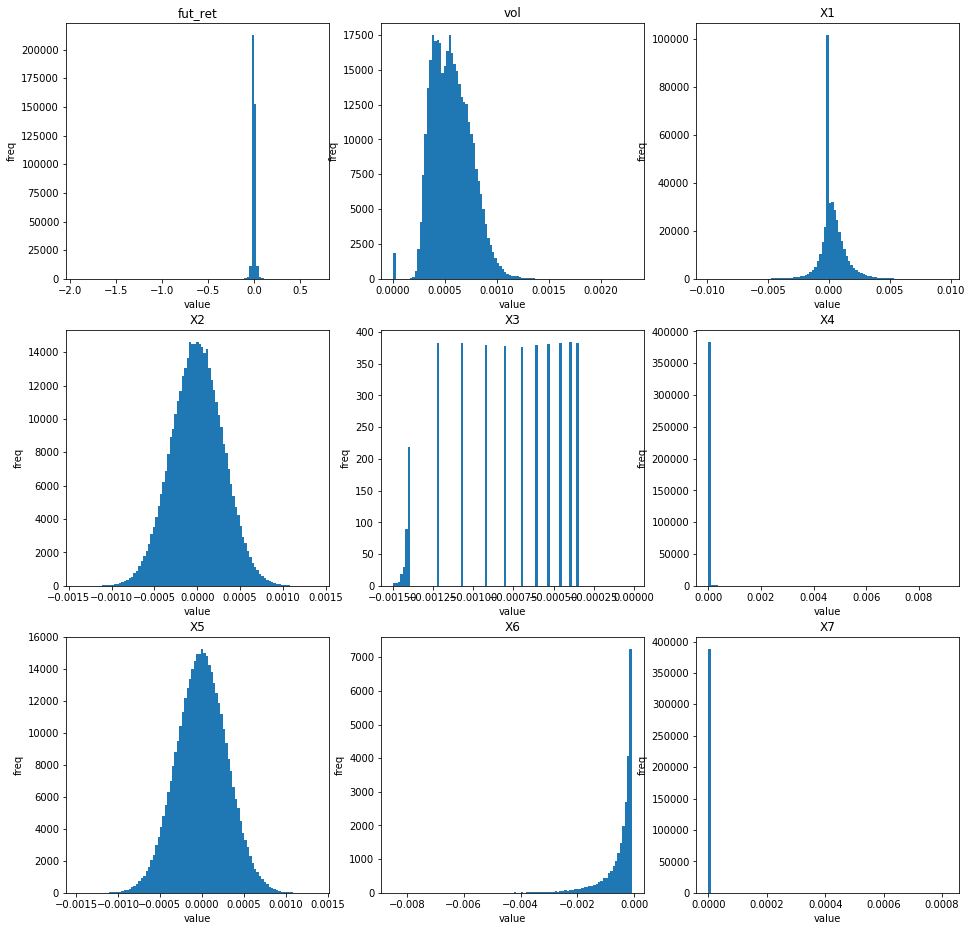

In [6]:
plt.figure(figsize=(16, 16))

for idx, column in enumerate(data.columns[2:]):
    plt.subplot(3, 3, idx+1)
    # extract all valid data in this column.
    data_col_vld = data[column][~np.isnan(data[column])]
    # plot population histogram across time.
    plt.hist(data_col_vld, bins=np.arange(min(data_col_vld), max(data_col_vld),\
                                          (max(data_col_vld)-min(data_col_vld))/100))
    plt.xlabel('value')
    plt.ylabel('freq')
    plt.title(column)
plt.show()

We can find that 'X2' and 'X5' are very likely to be pure white noise (or at least the cases where white noise just overwhelms our signal), because they are bell-shaped, and not skewed.

'X1' has a large portion of data very close to 0. Therefore, I think though there is some composition of white noise in 'X1', but it is not pure noise.

But before further investigating into that, let's reshape our data, such that each feature (as well as return is) one dataframe, indexed by date with each ticker per column.

## 1.5. Reshape data.

In [7]:
# reshape data to make each feature one dataframe.
# index: date
# column: ticker
fut_ret = data.pivot(index='Date', columns='sec_id', values='fut_ret')
vol = data.pivot(index='Date', columns='sec_id', values='vol')
X1 = data.pivot(index='Date', columns='sec_id', values='X1')
X2 = data.pivot(index='Date', columns='sec_id', values='X2')
X3 = data.pivot(index='Date', columns='sec_id', values='X3')
X4 = data.pivot(index='Date', columns='sec_id', values='X4')
X5 = data.pivot(index='Date', columns='sec_id', values='X5')
X6 = data.pivot(index='Date', columns='sec_id', values='X6')
X7 = data.pivot(index='Date', columns='sec_id', values='X7')

## 1.6. Deal with Missing Values.

First let's find out how many np.nans in raw data and our reshaped data.

Number of np.nan each column in raw data is as follows.

In [8]:
print(' in raw data, number of np.nan in each column:')
np.sum(np.isnan(data_raw), axis=0)

 in raw data, number of np.nan in each column:


Date           0
Time           0
sec_id         0
fut_ret        0
vol        30098
X1             0
X2             0
X3             0
X4             0
X5             0
X6             0
X7             0
dtype: int64

Number of np.nan for each feature in reshaped data is as follows.

In [9]:
feature_name_lst = ['fut_ret', 'vol', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']
feature_lst = [fut_ret, vol, X1, X2, X3, X4, X5, X6, X7]

print('after reshaping, number of np.nan in each feature dataframe:')
for i in range(len(feature_lst)):
    print('number of np.nan in '+feature_name_lst[i]+': %d'\
          %np.sum(np.sum(np.isnan(feature_lst[i]))))

after reshaping, number of np.nan in each feature dataframe:
number of np.nan in fut_ret: 5861
number of np.nan in vol: 35959
number of np.nan in X1: 5861
number of np.nan in X2: 5861
number of np.nan in X3: 5861
number of np.nan in X4: 5861
number of np.nan in X5: 5861
number of np.nan in X6: 5861
number of np.nan in X7: 5861


Now we can find that after reshaping, there are a lot more missing values than before. This is probably because that in original raw data, different stocks have slightly different time stamps.

Let's see how many tickers and dates have missing values in 'fut_ret'. If the missing values are concentrated within a few tickers or dates, we can just discard them.

In [10]:
print('number of dates containing np.nan: %d' %\
     np.sum(np.sum(np.isnan(fut_ret), axis=1)==0))

number of dates containing np.nan: 12


In [11]:
print('number of tickers containing np.nan: %d' %\
     np.sum(np.sum(np.isnan(fut_ret), axis=0)==0))

number of tickers containing np.nan: 1541


1,541 (77.4%) tickers and 12 (6%) dates have np.nan. There is no way we can just drop a whole column or row in our dataframe.

There are two most common possibilities for missing values in a time series:
1. A few np.nans lie in between valid data in a time series.
2. A big chunk (or all) of data at the beginning (or in the middle) of our time period.

Most of np.nan in features except for 'vol' are probably case 1. Let's deal with them first.

### 1.6.1 np.nans in Features other than 'vol'.

Due to our discussion before, in different feature dataframes (such as 'fut_ret' and 'X7'), all np.nans are in the same place. So if we fill the missing values using some moving average (such as exponential moving average), we will get $\frac{5861}{392539}\approx1.5\%$ of our data points among which all the features are just filled in artificially. That is unacceptable.

- Thus we have to drop them in the end and leave the timestamps of the stocks somewhat different.

### 1.6.2 np.nans in 'vol'.

But 'vol' is a label with relative small noise and lots of np.nans. We have to fill (at least some of) them in some way.

One way to fill np.nan is to use exponential moving average. We implement the moving average w.r.t. historical data in order to avoid lookahead bias.

But there is one parameter we have to decide: the center of mass (or effective lag of our moving average).

There are two concerns:
1. we do not want to use a too long window length, because that will incorporate too much old information;
2. we do not want to use a too short window length either, because it will inherit the noise of its previous observation.

Therefore, we have to do some kind of parameter tuning.

Notice that 'sec_id' as a strong correlation with 'vol'. Thus, one way to decide is that we try different window lengths of filling volatility, and pick the one with the strongest correlation with 'sec_id'.

In [12]:
corr_vol_ret = []
window_lst = np.arange(1, 21)

# for each window length, use EMA to fill vol.
# then calculate pearsonr w.r.t. sec_id.
for window in window_lst:
    vol_ema = vol.fillna(vol.ewm(window).mean())
    sec_id_ndarr = np.tile(vol.columns, (len(vol.index), 1))
    
    # we need to handle np.nan properly.
    both_valid = (~np.isnan(vol_ema)) & (~np.isnan(sec_id_ndarr))
    vol_ema_vld_arr = vol_ema[both_valid].values.reshape((1, -1))[0]
    sec_id_vld_arr = sec_id_ndarr[both_valid].reshape((1, -1))[0]
    
    corr_vol_ret.append(pearsonr(vol_ema_vld_arr[~np.isnan(vol_ema_vld_arr)],\
                                 sec_id_vld_arr[~np.isnan(sec_id_vld_arr)])[0])

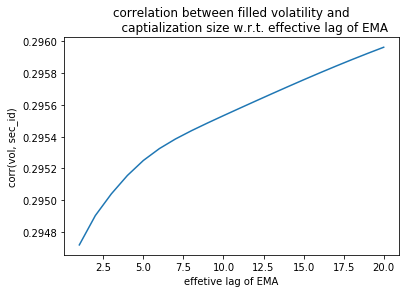

In [13]:
plt.plot(window_lst, corr_vol_ret)
plt.xlabel('effetive lag of EMA')
plt.ylabel('corr(vol, sec_id)')
plt.title('correlation between filled volatility and\n\
            captialization size w.r.t. effective lag of EMA')
plt.show()

We are disappointed to see that the correlation keeps going up, and a EMA with $lag>15$ actually does not make sense.

Thus, we turn to the second strongest correlation: 'vol' and 'X1'.

In [14]:
corr_vol_ret = []
window_lst = np.arange(1, 16)

# for each window length, use EMA to fill vol.
# then calculate pearsonr w.r.t. X1.
for window in window_lst:
    vol_ema = vol.fillna(vol.ewm(window).mean())
    
    # we need to handle np.nan properly.
    both_valid = (~np.isnan(vol_ema)) & (~np.isnan(X1))
    vol_ema_vld_arr = vol_ema[both_valid].values.reshape((1, -1))[0]
    X1_vld_arr = X1[both_valid].values.reshape((1, -1))[0]
    
    corr_vol_ret.append(pearsonr(vol_ema_vld_arr[~np.isnan(vol_ema_vld_arr)],\
                                 X1_vld_arr[~np.isnan(X1_vld_arr)])[0])

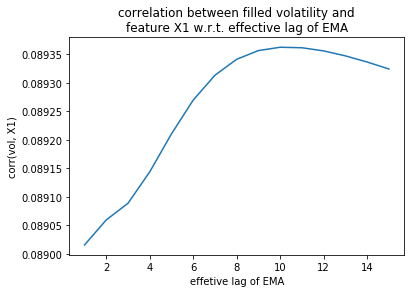

In [15]:
plt.plot(window_lst, corr_vol_ret)
plt.xlabel('effetive lag of EMA')
plt.ylabel('corr(vol, X1)')
plt.title('correlation between filled volatility and\nfeature X1 w.r.t. effective lag of EMA')
plt.show()

In [16]:
# find best window length.
window_lst[np.argmax(np.array(corr_vol_ret))]

10

- Based on this plot, we will choose $lag=10$.

Let's see if there are consecutive np.nans in the middle of time series.

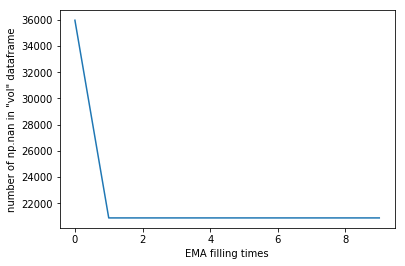

In [17]:
vol_nan_num_lst = []
for i in range(0, 10):
    if i==0:
        pass
    else:
        vol = vol.fillna(vol.ewm(10).mean())
    vol_nan_num_lst.append(np.sum(np.sum(np.isnan(vol))))

plt.figure()
plt.plot(np.arange(0, 10), vol_nan_num_lst)
plt.xlabel('EMA filling times')
plt.ylabel('number of np.nan in "vol" dataframe')
plt.show()

In [18]:
np.sum(np.sum(np.isnan(vol)))

20887

Let's see again how many tickers and dates contain np.nan.

In [19]:
print('number of dates containing np.nan: %d' %\
     np.sum(np.sum(np.isnan(fut_ret), axis=1)==0))
print('number of tickers containing np.nan: %d' %\
     np.sum(np.sum(np.isnan(fut_ret), axis=0)==0))

number of dates containing np.nan: 12
number of tickers containing np.nan: 1541


Now let's take a look at how number of np.nan changes w.r.t. dates.

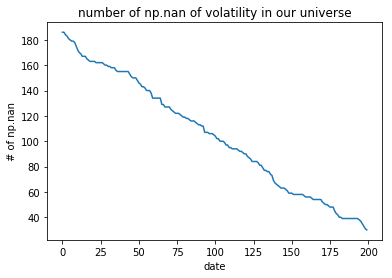

In [20]:
plt.plot(np.sum(np.isnan(vol), axis=1))
plt.xlabel('date')
plt.ylabel('# of np.nan')
plt.title('number of np.nan of volatility in our universe') 
plt.show()

Here we kind of know what is going on. As time goes by, the number of np.nan in volatility dataframe decreases monotonically. It is very likely to be the case that some stocks do not have any obersevation of volatility at the beginning; but later more and more stocks tend of have valid volatility observations.

Thus, the most reasonable way tends to be the following: 
1. fill as many np.nans as possible by using exponential movnig average. (Note that this is already done.)
2. fill all remaining np.nans by 0.

At start, when a stock does not have any volaitlity observation, we simply assign it to be 0 in order to 'shutdown the neuron' in regression or neural network; we only start to consider the effect of volatility for this stock from the moment when it has valid observations.

In [21]:
# vol = vol.fillna(0)
np.sum(np.sum(np.isnan(vol)))

20887

## 1.7. Explore Which Features Are Dominated by Random Noise.

As discussed before, 'X2' and 'X5' are probably just noise. Let's verify our assumptions.

One way to further investigate whether a feature 'X' is noise is that for each ticker, we plot the 1st, 2nd and 3rd moment of 'X' across the time and see if the value vaies across each ticker.

- If it does not vary, X is probably noise;
- Otherwise X may contain some information.

In [22]:
# plot first three moments of feature X acorss each ticker.
def plot_mmt(X):
    fst_mmt = moment(X, moment=1, axis=0, nan_policy='omit')
    scd_mmt = moment(X, moment=2, axis=0, nan_policy='omit')
    trd_mmt = moment(X, moment=3, axis=0, nan_policy='omit')
    col = X.columns

    plt.figure(figsize=(18, 4))
    plt.subplot(1, 3, 1)
    plt.plot(col, fst_mmt, color='red')
    plt.xlabel('ticker')
    plt.ylabel('1st moment')

    plt.subplot(1, 3, 2)
    plt.plot(col, scd_mmt, color='blue')
    plt.xlabel('ticker')
    plt.ylabel('2nd moment')

    plt.subplot(1, 3, 3)
    plt.plot(col, trd_mmt, color='green')
    plt.xlabel('ticker')
    plt.ylabel('3rd moment')

    plt.show()

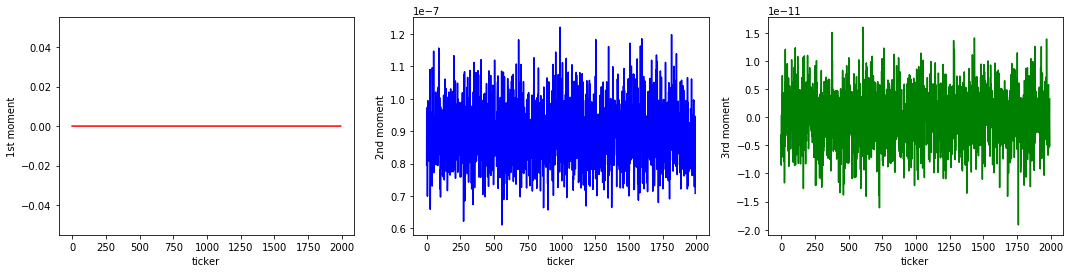

In [23]:
plot_mmt(X2)

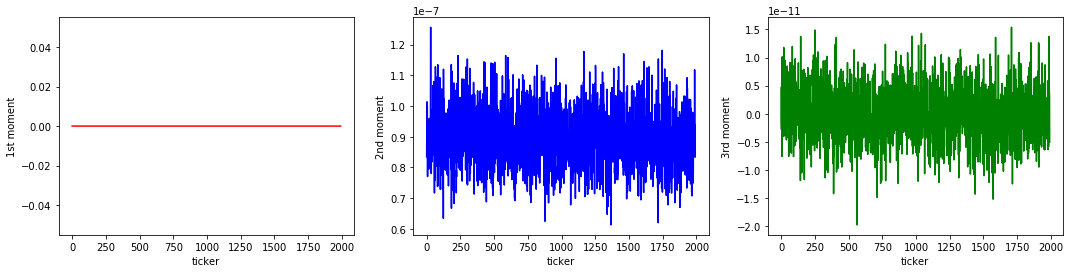

In [24]:
plot_mmt(X5)

- Now we can conclude that 'X2' and 'X5' are just noise.

Let's consider 'X1' now.

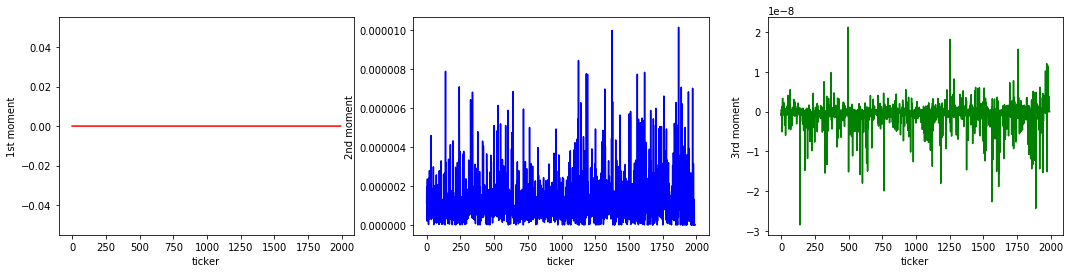

In [25]:
plot_mmt(X1)

- From the 2nd and 3rd moment, there is some information in 'X1'. I will not drop it.

## 1.9. Put Everything Together.

Now we concatenate each feature back into one dataframe, just like our original raw data.

In [26]:
date_ndarr = np.tile(fut_ret.index, (fut_ret.shape[1], 1)).T
sec_id_ndarr = np.tile(fut_ret.columns, (fut_ret.shape[0], 1))

data = np.array([date_ndarr.reshape(-1,), sec_id_ndarr.reshape(-1,),\
                fut_ret.values.reshape(-1,), vol.values.reshape(-1,),\
                X1.values.reshape(-1,), X3.values.reshape(-1,),\
                X4.values.reshape(-1,), X6.values.reshape(-1,),\
                X7.values.reshape(-1,)]).T

data = pd.DataFrame(data, columns=['Date', 'sec_id', 'fut_ret', 'vol', 'X1',\
                                   'X3', 'X4', 'X6', 'X7'])

In [27]:
np.sum(np.isnan(data), axis=0)

Date           0
sec_id         0
fut_ret     5861
vol        20887
X1          5861
X3          5861
X4          5861
X6          5861
X7          5861
dtype: int64

Then we drop the missing observations for tickers, as discussed above.

In [28]:
data = data.drop(data['fut_ret'][np.isnan(data['fut_ret'])].index)

Finanlly let's check if there are still any np.nans in our dataframe, and whether the new dataframe has the same length with raw data.

In [29]:
print('number of np.nan in each column:')
print(np.sum(np.isnan(data), axis=0))
print('shape of new data:')
print(data.shape)
print('shape of raw data:')
print(data_raw.shape)

number of np.nan in each column:
Date           0
sec_id         0
fut_ret        0
vol        20887
X1             0
X3             0
X4             0
X6             0
X7             0
dtype: int64
shape of new data:
(392539, 9)
shape of raw data:
(392539, 12)


## 1.8. Normalize Data.

The final step is to normalize our data.

There are four cases:

1. sec_id, Date: we will devide each value by the sample maximum.
2. X2, X5: we will not normalize them because we will drop them in the end anyway.
3. vol: we will first add a minor positive number in order to avoid numerical error, and then take log and compute z-score.
3. X1, X3, X4, X6, X7: we will compute z-score of them directly.

In [30]:
# dictionaries to keep sample mean and std.
# need to use them in prediction step.
mean_dict, std_dict = {}, {}

In [31]:
for column in ['X1', 'X3', 'X4', 'X6', 'X7']:
    feature = data[column]
    
    mean_dict[column] = feature.mean(skipna=True)
    std_dict[column] = feature.std(skipna=True)
    print('for '+column+' :')
    print('mean = %.9f' %mean_dict[column])
    print('std = %.9f' %std_dict[column])
    
    feature = (feature-mean_dict[column])/std_dict[column]
    data[column+'_norm'] = feature

for X1 :
mean = 0.000315003
std = 0.001151351
for X3 :
mean = -0.000008210
std = 0.000086272
for X4 :
mean = 0.000031030
std = 0.000282459
for X6 :
mean = -0.000036779
std = 0.000203316
for X7 :
mean = 0.000001353
std = 0.000016784


In [32]:
data['Date'] = data['Date']/data['Date'].max()
data['sec_id'] = data['sec_id']/data['sec_id'].max()

In [33]:
data['log_vol'] = np.log(data['vol'].fillna(0)+(1e-4))
mean_dict['log_vol'] = data['log_vol'].mean(skipna=True)
std_dict['log_vol'] = data['log_vol'].std(skipna=True)

print('for modified log vol (+1e-4, then take np.log):')
print('mean = %.9f' %mean_dict['log_vol'])
print('std = %.9f' %std_dict['log_vol'])

data['log_vol'] = (data['log_vol']-mean_dict['log_vol'])/std_dict['log_vol']
# data = data.drop(columns=['vol'])

for modified log vol (+1e-4, then take np.log):
mean = -7.456139355
std = 0.510118379


In [34]:
print('shape of new data:')
print(data.shape)
print('shape of raw data:')
print(data_raw.shape)
print('number of np.nan in each column')
print(np.sum(np.isnan(data), axis=0))

shape of new data:
(392539, 15)
shape of raw data:
(392539, 12)
number of np.nan in each column
Date           0
sec_id         0
fut_ret        0
vol        20887
X1             0
X3             0
X4             0
X6             0
X7             0
X1_norm        0
X3_norm        0
X4_norm        0
X6_norm        0
X7_norm        0
log_vol        0
dtype: int64


## 1.9. Save Trimmed Data into a .csv File and Print Mean and Std Dictionaries.

In [35]:
data.to_csv('trimmed_data_v3.csv')

In [36]:
print('mean dictionary:')
for key, value in mean_dict.items():
    print('mean of '+key+' = %.10f' %value)

print('std dictionary:')
for key, value in std_dict.items():
    print('std of '+key+' = %.10f' %value)

mean dictionary:
mean of X1 = 0.0003150029
mean of X3 = -0.0000082097
mean of X4 = 0.0000310304
mean of X6 = -0.0000367788
mean of X7 = 0.0000013526
mean of log_vol = -7.4561393545
std dictionary:
std of X1 = 0.0011513509
std of X3 = 0.0000862716
std of X4 = 0.0002824588
std of X6 = 0.0002033164
std of X7 = 0.0000167842
std of log_vol = 0.5101183787


Note that when trimming 'vol', we need to first add 1e-4, take log and then normalize using mean and std above.